# Problem framing

![Cover image](cover.png)

The task of this project is to perform semantic segmentation using the DeepLabv3+ model on drone imagery from the AeroScapes dataset. It involves labeling each pixel in the image with a class label, enabling precise identification and delineation of various objects and features in urban and rural landscapes captured by aerial photography.


## AeroScapes dataset
The AeroScapes aerial semantic segmentation benchmark comprises of images captured using a commercial drone (UAV) from an altitude range of 5 to 50 metres. The dataset provides 3,269 720p images and ground-truth masks for 11 classes.

## Class labels
- vegetation
- roads
- sky
- construction
- person
- bikes
- cars
- drones
- boats
- obstacles
- animals

## Folder structure
```
aeroscapes/
    JPEGImages/
        3269 RGB images.
    SegmentationClass/
        3269 ground-truth segmentation masks.
    Visualizations/
        3269 RGB ground-truth segmentation visualizations.
    ImageSets/
        Training and validation splits for data.
```

## Dataset Reference:
[Aeroscapes Dataset (Nigam et al., 2018)](https://www.kaggle.com/datasets/kooaslansefat/uav-segmentation-aeroscapes/data)

# Define Hyperparameters

In [4]:
# General
LEARNING_RATE = 1e-4 # 0.0001
BATCH_SIZE = 16
EPOCHS = 50

# DeepLabv3+ Specific
ENCODER_NAME = "resnext50_32x4d"
ENCODER_DEPTH = 5
ENCODER_WEIGHTS = "imagenet"
ENCODER_OUTPUT_STRIDE = 16
DECODER_ATROUS_RATES = (6, 12, 18)
DECODER_CHANNELS = 256
IN_CHANNELS = 3 # RGB
UPSAMPLING = 4

# Import common dependencies

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA GPU is available

In [6]:
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of GPUs available:", torch.cuda.device_count())
    print("Current GPU device:", torch.cuda.current_device())
    print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. PyTorch will use the CPU.")

CUDA is available. PyTorch can use the GPU.
Number of GPUs available: 1
Current GPU device: 0
GPU name: NVIDIA GeForce RTX 3060 Laptop GPU


# Data Preprocessing and Augmentation

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

# Use ImageNet normalization parameters
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Define image dimensions
im_h, im_w = 256, 256

# Perform augmentations
trans = A.Compose([
    A.Resize(im_h, im_w),  
    A.RandomResizedCrop(im_h, im_w, scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),  
    A.RandomBrightnessContrast(p=0.2),  
    A.ShiftScaleRotate(p=0.2), 
    A.Normalize(mean, std),
    ToTensorV2(transpose_mask=True) 
])

# Visualize augmentations

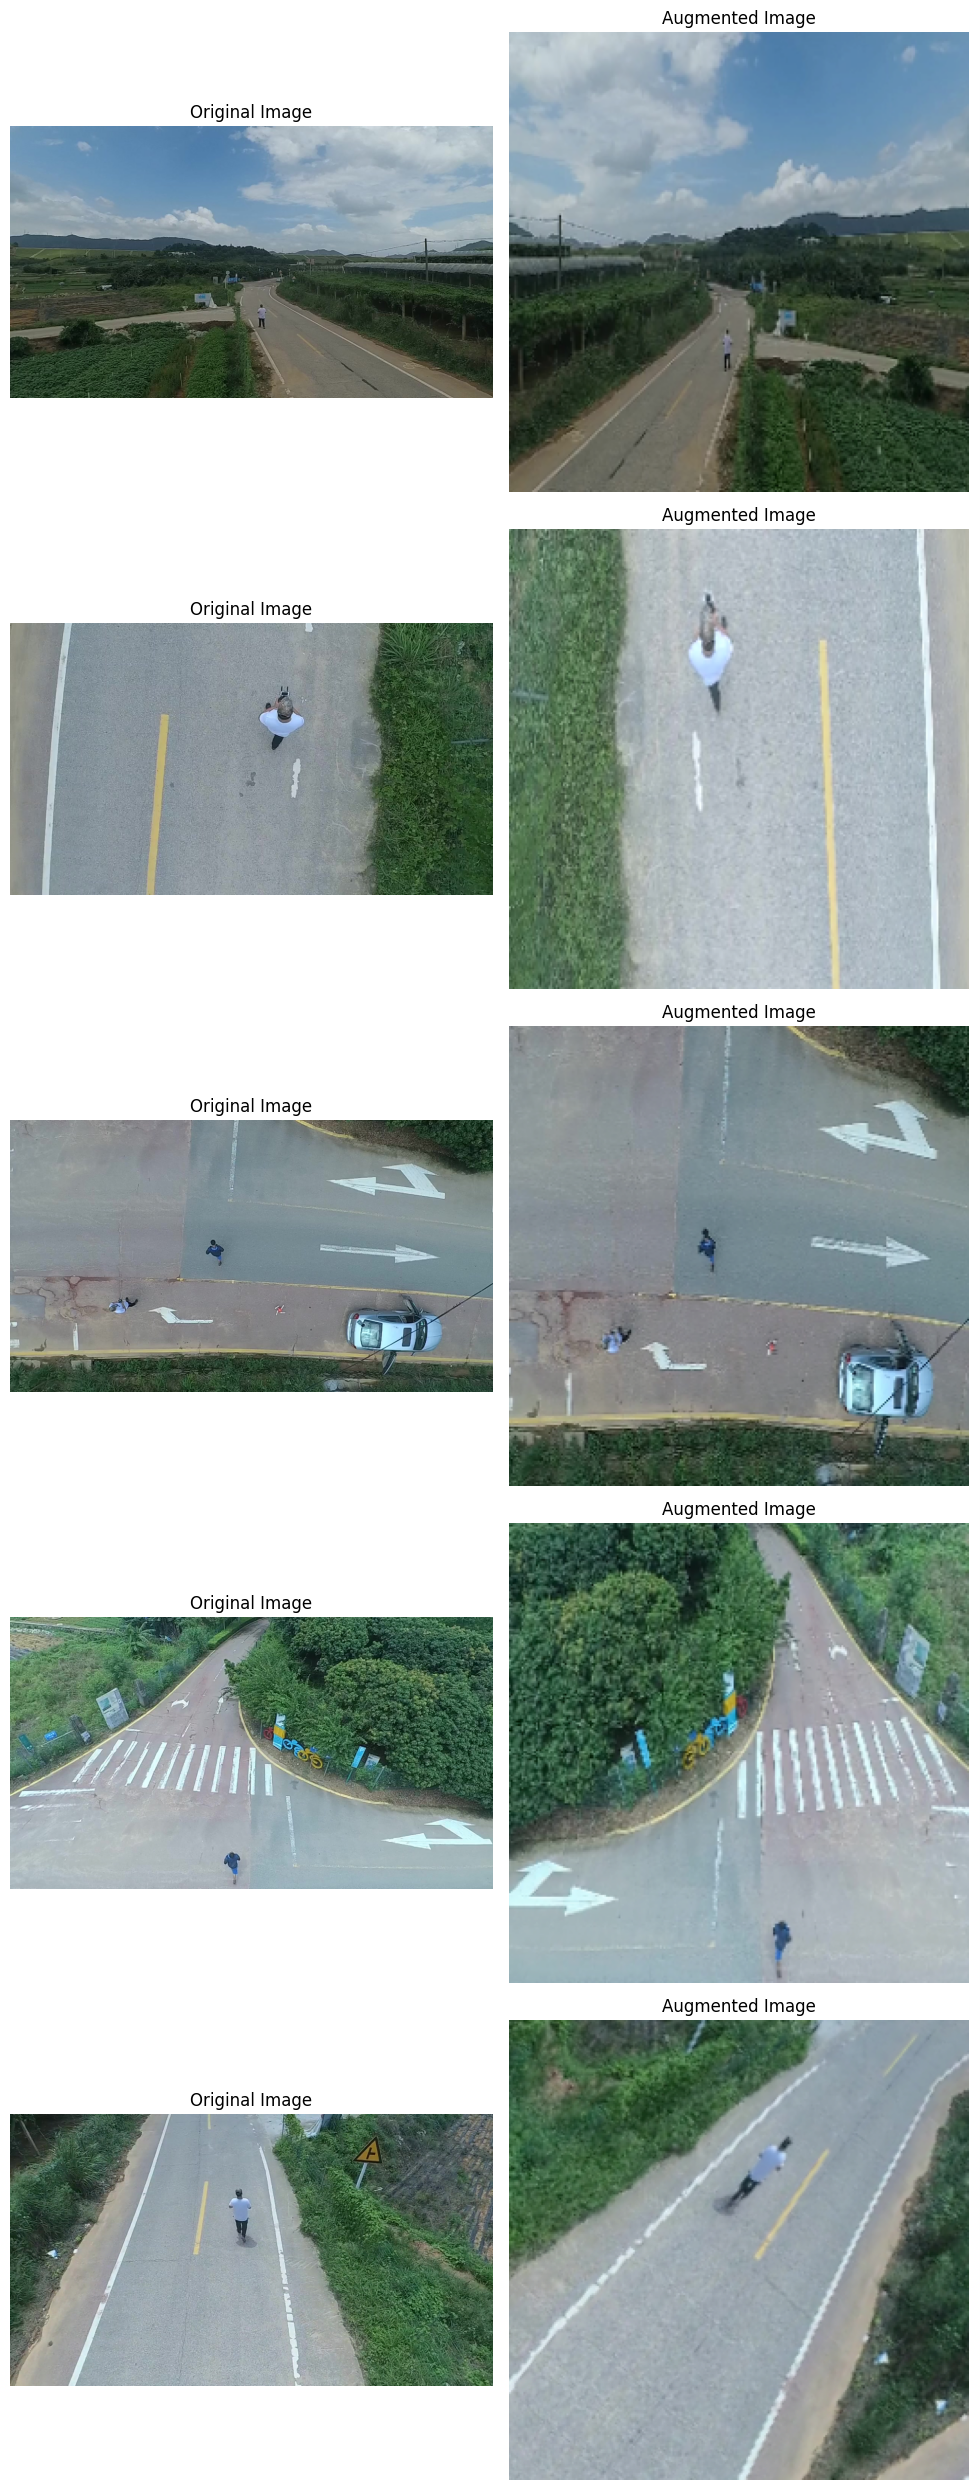

In [8]:
# List of image paths (replace with your actual image paths)
image_paths = [
    "/home/red/notebooks/ai_project_deeplabv3plus_aeroscapes/aeroscapes/JPEGImages/000001_001.jpg",
    "/home/red/notebooks/ai_project_deeplabv3plus_aeroscapes/aeroscapes/JPEGImages/000003_001.jpg",
    "/home/red/notebooks/ai_project_deeplabv3plus_aeroscapes/aeroscapes/JPEGImages/000004_001.jpg",
    "/home/red/notebooks/ai_project_deeplabv3plus_aeroscapes/aeroscapes/JPEGImages/000005_001.jpg",
    "/home/red/notebooks/ai_project_deeplabv3plus_aeroscapes/aeroscapes/JPEGImages/000002_009.jpg",
]

# Plotting multiple images
num_images = len(image_paths)
fig, axes = plt.subplots(num_images, 2, figsize=(10, 5*num_images))

for i, img_path in enumerate(image_paths):
    # Load the image
    img = Image.open(img_path)
    
    # Convert PIL image to numpy array
    img_np = np.array(img)
    
    # Apply augmentation to the image
    augmented = trans(image=img_np)['image']
    
    # Convert augmented image tensor to numpy array for visualization
    augmented_np = augmented.permute(1, 2, 0).cpu().numpy()
    augmented_np = (augmented_np * std + mean).clip(0, 1)
    
    # Convert numpy array to PIL Image for visualization
    augmented_pil = Image.fromarray((augmented_np * 255).astype(np.uint8))
    
    # Plotting original image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')
    
    # Plotting augmented image
    axes[i, 1].imshow(augmented_pil)
    axes[i, 1].set_title('Augmented Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Create dataset class

In [9]:
import os
import cv2
from glob import glob
from torch.utils.data import Dataset

class AeroscapesDataset(Dataset):
    
    def __init__(self, root, data="trn", transformations=None):
        files = open(f"{root}/ImageSets/{data}.txt", "r").read().split("\n")
        self.im_paths, self.gt_paths = self.get_data_paths(root=root, files=files)
        self.transformations = transformations
        self.n_cls = 11

        assert len(self.im_paths) == len(self.gt_paths)

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im, gt = self.get_im_gt(self.im_paths[idx], self.gt_paths[idx])

        if self.transformations: 
            transformed = self.transformations(image=im, mask=gt)
            im, gt = transformed["image"], transformed["mask"]

        return im, gt

    def get_im_gt(self, im_path, gt_path):
        return self.read_im(im_path), self.read_im(gt_path)

    def get_data_paths(self, root, files):
        return (
            [path for path in sorted(glob(f"{root}/JPEGImages/*.jpg")) if self.get_fname(path) in files],
            [path for path in sorted(glob(f"{root}/Visualizations/*.png")) if self.get_fname(path) in files]
        )

    def get_fname(self, path):
        return os.path.splitext(os.path.basename(path))[0]

    def read_im(self, path): 
        return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)


# Create dataloader

In [10]:
import torch
from torch.utils.data import DataLoader, random_split

def get_dls(root, transformations, bs, split=[0.7, 0.1, 0.2], ns=8):

    assert sum(split) == 1., "Sum of the split must be exactly 1"

    # Create dataset
    dataset = AeroscapesDataset(root=root, data="trn", transformations=transformations)
    n_cls = dataset.n_cls
    total_len = len(dataset)

    # Calculate lengths for train, val, test splits
    tr_len = int(total_len * split[0])
    val_len = int(total_len * split[1])
    test_len = total_len - tr_len - val_len

    # Random split dataset into train, val, test
    tr_ds, val_ds, ts_ds = random_split(dataset, [tr_len, val_len, test_len])

    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(ts_ds)} number of images in the test set\n")

    # Create dataloaders
    tr_dl = DataLoader(dataset=tr_ds, batch_size=bs, shuffle=True, num_workers=ns)
    val_dl = DataLoader(dataset=val_ds, batch_size=bs, shuffle=False, num_workers=ns)
    test_dl = DataLoader(dataset=ts_ds, batch_size=1, shuffle=False, num_workers=ns)

    return tr_dl, val_dl, test_dl, n_cls


In [11]:
root = "/home/red/notebooks/ai_project_deeplabv3plus_aeroscapes/aeroscapes/"
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = BATCH_SIZE)


There are 1834 number of images in the train set
There are 262 number of images in the validation set
There are 525 number of images in the test set



# Visualize images and their segmentation masks

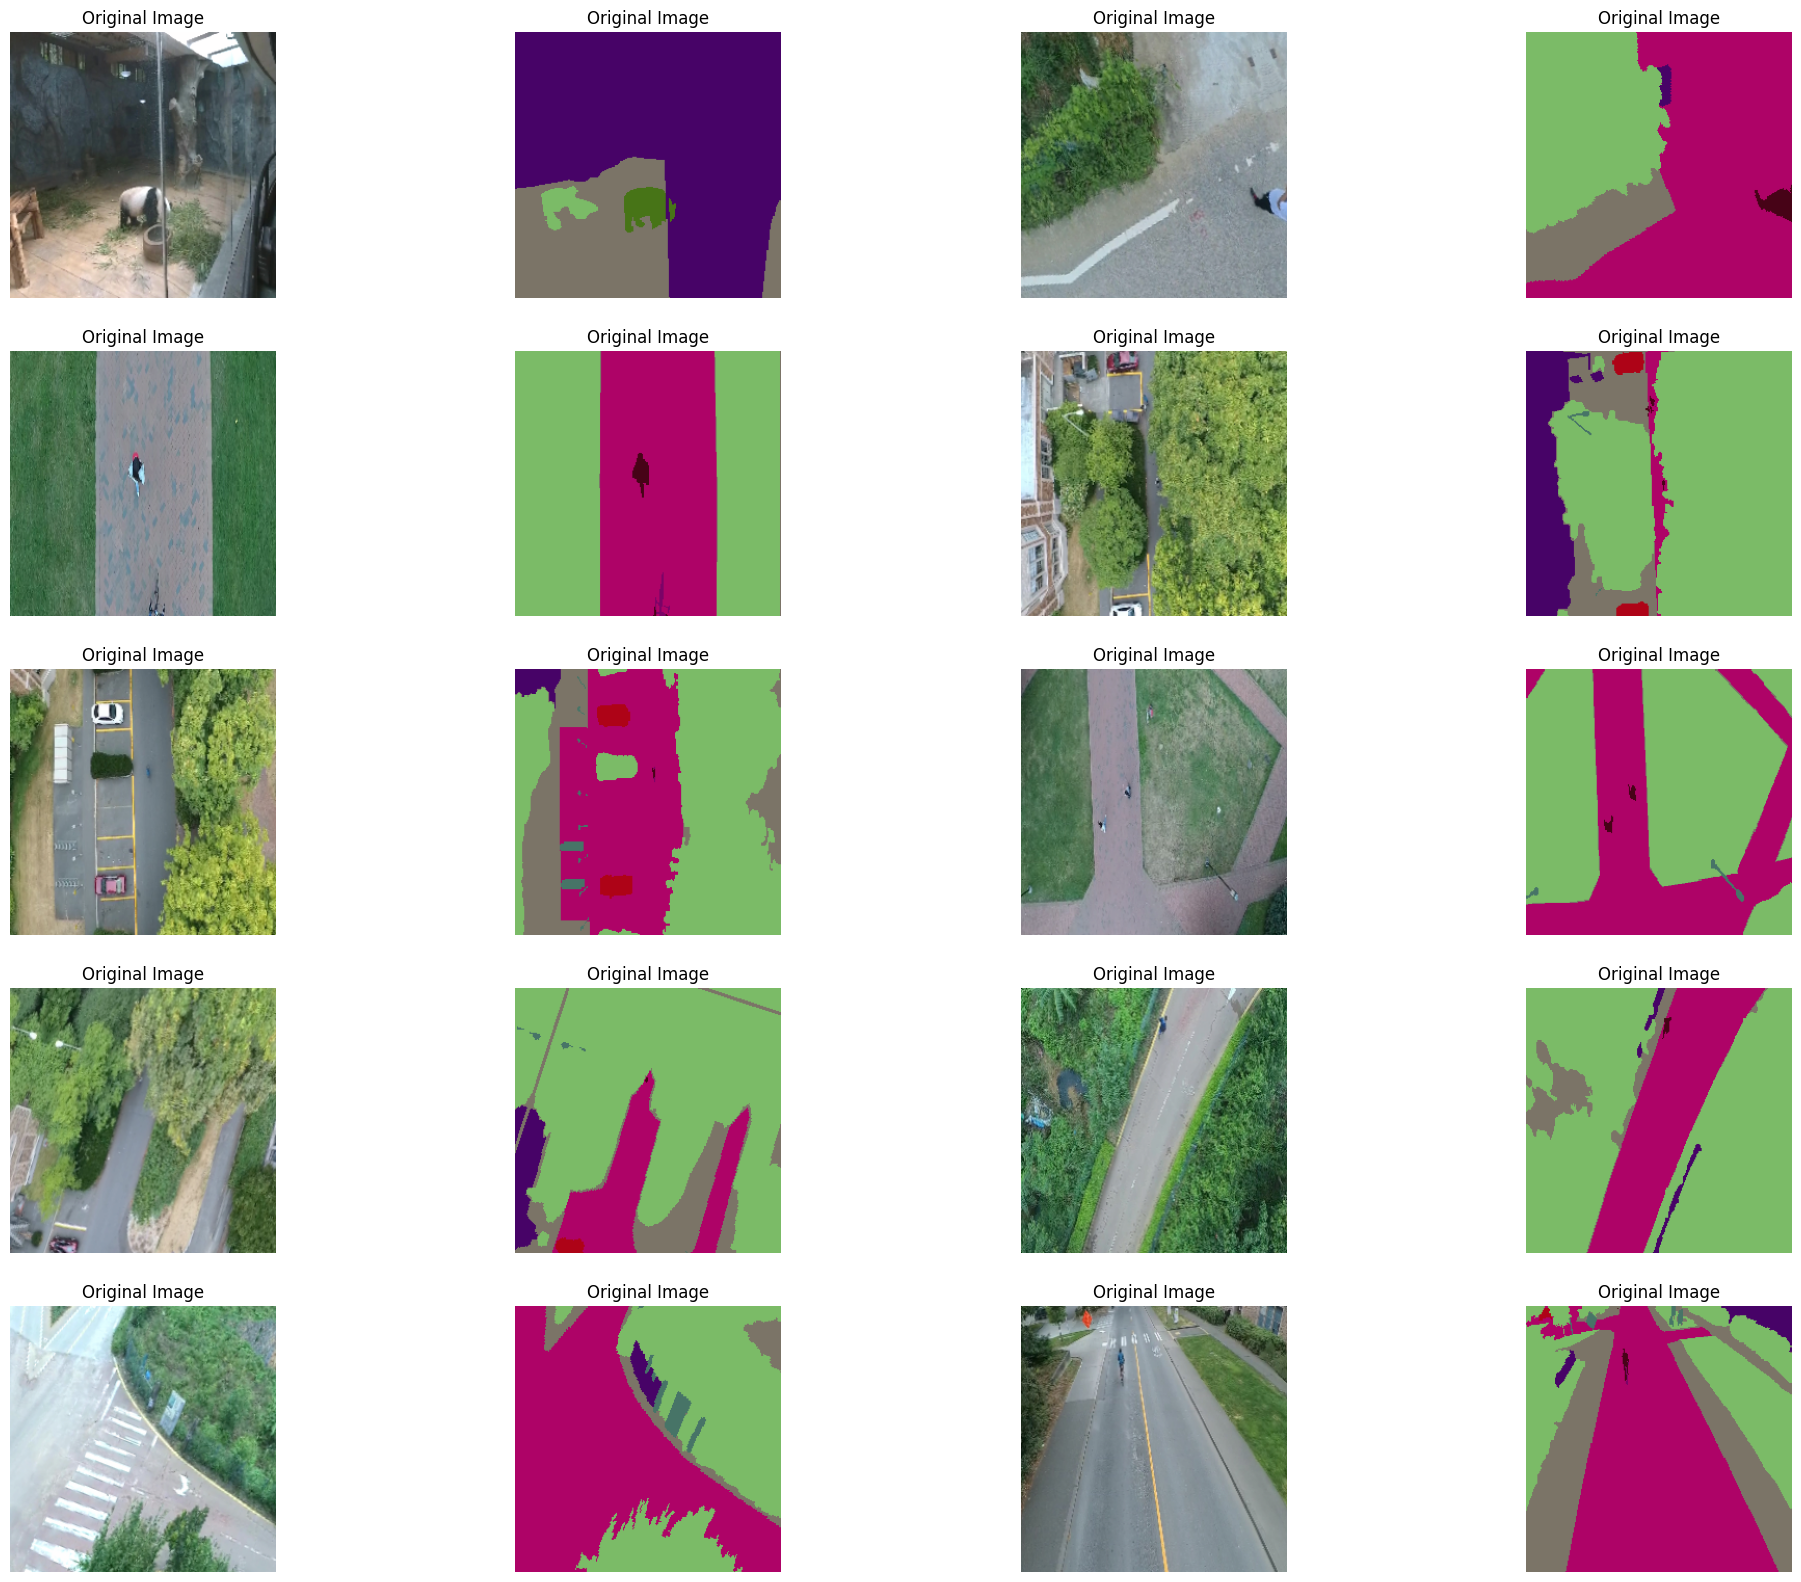

In [12]:
import random
from torchvision import transforms as tfs

def tn_2_np(t):
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])

    rgb = True if len(t) == 3 else False

    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):

    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)

    return count + 1

def visualize(ds, n_ims):

    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds)) for _ in range(n_ims)]

    for idx, index in enumerate(indices):

        if count == n_ims + 1: break
        im, gt = ds[index]

        # First Plot
        count = plot(rows, cols, count, im = im)

        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True)

visualize(tr_dl.dataset, n_ims = 20)


# Model selection: DeepLabv3+

DeepLabv3+ is a semantic segmentation model that builds upon DeepLabv3 by incorporating a decoder module to refine segmentation results, particularly along object boundaries. It utilizes Atrous Spatial Pyramid Pooling (ASPP) to capture multi-scale context and enhance feature extraction, while the encoder-decoder structure enables precise localization of segmentation masks. 

## Encoder
- Utilizes a deep convolutional neural network (e.g., ResNet, Xception, ResNeXt) as the backbone.
- Employs Atrous Convolution (dilated convolution) to increase the receptive field without reducing spatial resolution, capturing multi-scale context.

## Decoder
- Refines segmentation results, especially along object boundaries.
- Upsamples the low-resolution encoder feature maps using bilinear interpolation.
- Concatenates the upsampled features with corresponding low-level features from the encoder.
- Applies convolutions to refine the concatenated features, producing high-resolution feature maps.

![DeepLabv3+ architecture](deeplab_archi.png)


In [10]:
# !pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp
import time
from tqdm import tqdm
from torch.nn import functional as F
from torchinfo import summary

# Initialize model w/ defined hyperparameters
model = smp.DeepLabV3Plus(
    encoder_name = ENCODER_NAME,
    encoder_depth = ENCODER_DEPTH,
    encoder_weights = ENCODER_WEIGHTS,
    encoder_output_stride = ENCODER_OUTPUT_STRIDE,
    decoder_atrous_rates = DECODER_ATROUS_RATES,
    decoder_channels = DECODER_CHANNELS,
    in_channels = IN_CHANNELS,
    upsampling = UPSAMPLING,
    classes = n_cls
)

# Use cross-entropy for loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Use adam optimizer with defined learning rate
optimizer = torch.optim.Adam(
    params = model.parameters(), 
    lr = LEARNING_RATE
)

# Display model summary
summary(model)

Layer (type:depth-idx)                                  Param #
DeepLabV3Plus                                           --
├─ResNetEncoder: 1-1                                    --
│    └─Conv2d: 2-1                                      9,408
│    └─BatchNorm2d: 2-2                                 128
│    └─ReLU: 2-3                                        --
│    └─MaxPool2d: 2-4                                   --
│    └─Sequential: 2-5                                  --
│    │    └─Bottleneck: 3-1                             63,488
│    │    └─Bottleneck: 3-2                             71,168
│    │    └─Bottleneck: 3-3                             71,168
│    └─Sequential: 2-6                                  --
│    │    └─Bottleneck: 3-4                             349,184
│    │    └─Bottleneck: 3-5                             282,624
│    │    └─Bottleneck: 3-6                             282,624
│    │    └─Bottleneck: 3-7                             282,624
│    └─Sequenti

# Evaluation metrics

In [11]:
class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):
        self.pred, self.gt = torch.argmax(F.softmax(pred, dim=1), dim = 1), gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred
    
    def to_contiguous(self, inp):
        return inp.contiguous().view(-1)

    def PA(self):
        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()

        return float(match.sum()) / float(match.numel())

    def mIoU(self):
        with torch.no_grad():
            self.gt = torch.argmax(self.gt, dim = 1)

            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []

            for c in range(self.n_cls):
                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: 
                    iou_per_class.append(np.nan)   
                else:
                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()
                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)

            return np.nanmean(iou_per_class)

    def loss(self): 
        return self.loss_fn(self.pred_, torch.argmax(self.gt, dim = 1))

def tic_toc(start_time = None): 
    return time.time() if start_time == None else time.time() - start_time

# Build training and validation loop

In [12]:
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, save_path = "saved_models"):

    tr_loss = []
    tr_pa = [] 
    tr_iou = []
    
    val_loss = []
    val_pa = []
    val_iou = []
    
    tr_len = len(tr_dl)
    val_len = len(val_dl)
    
    best_loss = np.inf
    decrease = 1
    not_improve = 0
    early_stop_threshold = 10
    
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")

    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0

        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):

            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)

            preds = model(ims)

            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss()

            tr_iou_ += met.mIoU()

            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()

            loss_.backward()
            opt.step()
            opt.zero_grad()

        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()


        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)

        if best_loss > (val_loss_):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        if val_loss_ > best_loss:

            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")

    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(
    model = model, 
    tr_dl = tr_dl, 
    val_dl = val_dl,
    loss_fn = loss_fn, 
    opt = optimizer, 
    device = device,
    epochs = EPOCHS, 
    save_prefix = "aerospace"
)

Start training process...
Epoch 1 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:34<00:00,  3.77it/s]


Epoch 1 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.13it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 36.856 secs
Train Loss         -> 0.881
Train PA           -> 0.838
Train IoU          -> 0.705
Validation Loss    -> 0.453
Validation PA      -> 0.912
Validation IoU     -> 0.768

Loss decreased from inf to 0.453!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:33<00:00,  3.87it/s]


Epoch 2 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  8.51it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 35.872 secs
Train Loss         -> 0.237
Train PA           -> 0.956
Train IoU          -> 0.837
Validation Loss    -> 0.156
Validation PA      -> 0.965
Validation IoU     -> 0.856

Loss decreased from 0.453 to 0.156!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:34<00:00,  3.82it/s]


Epoch 3 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.91it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 36.413 secs
Train Loss         -> 0.148
Train PA           -> 0.965
Train IoU          -> 0.844
Validation Loss    -> 0.116
Validation PA      -> 0.968
Validation IoU     -> 0.862

Loss decreased from 0.156 to 0.116!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.73it/s]


Epoch 4 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.25it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 37.168 secs
Train Loss         -> 0.111
Train PA           -> 0.970
Train IoU          -> 0.867
Validation Loss    -> 0.097
Validation PA      -> 0.971
Validation IoU     -> 0.867

Loss decreased from 0.116 to 0.097!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:34<00:00,  3.76it/s]


Epoch 5 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.07it/s]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 36.944 secs
Train Loss         -> 0.094
Train PA           -> 0.972
Train IoU          -> 0.864
Validation Loss    -> 0.082
Validation PA      -> 0.973
Validation IoU     -> 0.871

Loss decreased from 0.097 to 0.082!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:34<00:00,  3.76it/s]


Epoch 6 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.43it/s]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 36.833 secs
Train Loss         -> 0.082
Train PA           -> 0.974
Train IoU          -> 0.874
Validation Loss    -> 0.081
Validation PA      -> 0.973
Validation IoU     -> 0.870

Loss decreased from 0.082 to 0.081!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.74it/s]


Epoch 7 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.30it/s]


Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 37.063 secs
Train Loss         -> 0.079
Train PA           -> 0.974
Train IoU          -> 0.861
Validation Loss    -> 0.073
Validation PA      -> 0.974
Validation IoU     -> 0.872

Loss decreased from 0.081 to 0.073!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:34<00:00,  3.75it/s]


Epoch 8 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.19it/s]


Epoch 8 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process results: 

Train Time         -> 36.979 secs
Train Loss         -> 0.074
Train PA           -> 0.975
Train IoU          -> 0.870
Validation Loss    -> 0.069
Validation PA      -> 0.975
Validation IoU     -> 0.875

Loss decreased from 0.073 to 0.069!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.74it/s]


Epoch 9 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.05it/s]


Epoch 9 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process results: 

Train Time         -> 37.140 secs
Train Loss         -> 0.069
Train PA           -> 0.976
Train IoU          -> 0.865
Validation Loss    -> 0.066
Validation PA      -> 0.976
Validation IoU     -> 0.876

Loss decreased from 0.069 to 0.066!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.72it/s]


Epoch 10 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.06it/s]


Epoch 10 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process results: 

Train Time         -> 37.299 secs
Train Loss         -> 0.064
Train PA           -> 0.977
Train IoU          -> 0.888
Validation Loss    -> 0.066
Validation PA      -> 0.975
Validation IoU     -> 0.875

Loss decreased from 0.066 to 0.066!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.69it/s]


Epoch 11 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.35it/s]


Epoch 11 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process results: 

Train Time         -> 37.555 secs
Train Loss         -> 0.064
Train PA           -> 0.976
Train IoU          -> 0.883
Validation Loss    -> 0.060
Validation PA      -> 0.977
Validation IoU     -> 0.889

Loss decreased from 0.066 to 0.060!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.69it/s]


Epoch 12 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.27it/s]


Epoch 12 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process results: 

Train Time         -> 37.612 secs
Train Loss         -> 0.059
Train PA           -> 0.978
Train IoU          -> 0.890
Validation Loss    -> 0.061
Validation PA      -> 0.977
Validation IoU     -> 0.896

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.71it/s]


Epoch 13 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.27it/s]


Epoch 13 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process results: 

Train Time         -> 37.371 secs
Train Loss         -> 0.080
Train PA           -> 0.972
Train IoU          -> 0.874
Validation Loss    -> 0.074
Validation PA      -> 0.971
Validation IoU     -> 0.868

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.71it/s]


Epoch 14 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.12it/s]


Epoch 14 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process results: 

Train Time         -> 37.391 secs
Train Loss         -> 0.072
Train PA           -> 0.973
Train IoU          -> 0.892
Validation Loss    -> 0.074
Validation PA      -> 0.972
Validation IoU     -> 0.870

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.67it/s]


Epoch 15 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.56it/s]


Epoch 15 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process results: 

Train Time         -> 37.991 secs
Train Loss         -> 0.063
Train PA           -> 0.976
Train IoU          -> 0.896
Validation Loss    -> 0.061
Validation PA      -> 0.976
Validation IoU     -> 0.886

Loss decreased from 0.074 to 0.061!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.65it/s]


Epoch 16 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.04it/s]


Epoch 16 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process results: 

Train Time         -> 38.060 secs
Train Loss         -> 0.056
Train PA           -> 0.978
Train IoU          -> 0.896
Validation Loss    -> 0.056
Validation PA      -> 0.978
Validation IoU     -> 0.897

Loss decreased from 0.061 to 0.056!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.69it/s]


Epoch 17 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.29it/s]


Epoch 17 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process results: 

Train Time         -> 37.591 secs
Train Loss         -> 0.055
Train PA           -> 0.979
Train IoU          -> 0.891
Validation Loss    -> 0.055
Validation PA      -> 0.978
Validation IoU     -> 0.896

Loss decreased from 0.056 to 0.055!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.68it/s]


Epoch 18 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.33it/s]


Epoch 18 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process results: 

Train Time         -> 37.934 secs
Train Loss         -> 0.052
Train PA           -> 0.980
Train IoU          -> 0.913
Validation Loss    -> 0.054
Validation PA      -> 0.978
Validation IoU     -> 0.897

Loss decreased from 0.055 to 0.054!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:36<00:00,  3.62it/s]


Epoch 19 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.29it/s]


Epoch 19 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process results: 

Train Time         -> 38.280 secs
Train Loss         -> 0.052
Train PA           -> 0.980
Train IoU          -> 0.912
Validation Loss    -> 0.055
Validation PA      -> 0.978
Validation IoU     -> 0.900

Loss did not decrease for 4 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:36<00:00,  3.64it/s]


Epoch 20 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.06it/s]


Epoch 20 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 train process results: 

Train Time         -> 38.141 secs
Train Loss         -> 0.051
Train PA           -> 0.980
Train IoU          -> 0.902
Validation Loss    -> 0.055
Validation PA      -> 0.978
Validation IoU     -> 0.898

Loss did not decrease for 5 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.67it/s]


Epoch 21 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.28it/s]


Epoch 21 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 train process results: 

Train Time         -> 37.788 secs
Train Loss         -> 0.050
Train PA           -> 0.980
Train IoU          -> 0.905
Validation Loss    -> 0.053
Validation PA      -> 0.979
Validation IoU     -> 0.895

Loss decreased from 0.055 to 0.053!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.67it/s]


Epoch 22 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.20it/s]


Epoch 22 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 train process results: 

Train Time         -> 37.738 secs
Train Loss         -> 0.049
Train PA           -> 0.981
Train IoU          -> 0.904
Validation Loss    -> 0.053
Validation PA      -> 0.979
Validation IoU     -> 0.905

Loss did not decrease for 6 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 23 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.65it/s]


Epoch 23 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.14it/s]


Epoch 23 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 23 train process results: 

Train Time         -> 38.017 secs
Train Loss         -> 0.048
Train PA           -> 0.981
Train IoU          -> 0.914
Validation Loss    -> 0.053
Validation PA      -> 0.979
Validation IoU     -> 0.899

Loss did not decrease for 7 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 24 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:36<00:00,  3.62it/s]


Epoch 24 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.03it/s]


Epoch 24 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 24 train process results: 

Train Time         -> 38.319 secs
Train Loss         -> 0.048
Train PA           -> 0.981
Train IoU          -> 0.915
Validation Loss    -> 0.051
Validation PA      -> 0.979
Validation IoU     -> 0.902

Loss decreased from 0.053 to 0.051!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 25 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:36<00:00,  3.64it/s]


Epoch 25 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.17it/s]


Epoch 25 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 25 train process results: 

Train Time         -> 38.090 secs
Train Loss         -> 0.046
Train PA           -> 0.981
Train IoU          -> 0.913
Validation Loss    -> 0.052
Validation PA      -> 0.979
Validation IoU     -> 0.907

Loss did not decrease for 8 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 26 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:36<00:00,  3.60it/s]


Epoch 26 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.97it/s]


Epoch 26 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 26 train process results: 

Train Time         -> 38.506 secs
Train Loss         -> 0.048
Train PA           -> 0.981
Train IoU          -> 0.907
Validation Loss    -> 0.054
Validation PA      -> 0.978
Validation IoU     -> 0.898

Loss did not decrease for 9 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 27 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:36<00:00,  3.61it/s]


Epoch 27 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.32it/s]


Epoch 27 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 27 train process results: 

Train Time         -> 38.311 secs
Train Loss         -> 0.047
Train PA           -> 0.981
Train IoU          -> 0.913
Validation Loss    -> 0.051
Validation PA      -> 0.980
Validation IoU     -> 0.904

Loss decreased from 0.054 to 0.051!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 28 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:35<00:00,  3.64it/s]


Epoch 28 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.09it/s]


Epoch 28 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 28 train process results: 

Train Time         -> 38.105 secs
Train Loss         -> 0.047
Train PA           -> 0.981
Train IoU          -> 0.916
Validation Loss    -> 0.050
Validation PA      -> 0.980
Validation IoU     -> 0.904

Loss decreased from 0.051 to 0.050!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 29 train process is started...


100%|█████████████████████████████████████████████████████████████| 131/131 [00:36<00:00,  3.63it/s]


Epoch 29 validation process is started...


100%|███████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.35it/s]

Epoch 29 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 29 train process results: 

Train Time         -> 38.178 secs
Train Loss         -> 0.046
Train PA           -> 0.981
Train IoU          -> 0.916
Validation Loss    -> 0.051
Validation PA      -> 0.979
Validation IoU     -> 0.906

Loss did not decrease for 10 epoch(s)!
Stopping training process becuase loss value did not decrease for 10 epochs!
Train process is completed in 18.187 minutes.


# Visualize training results

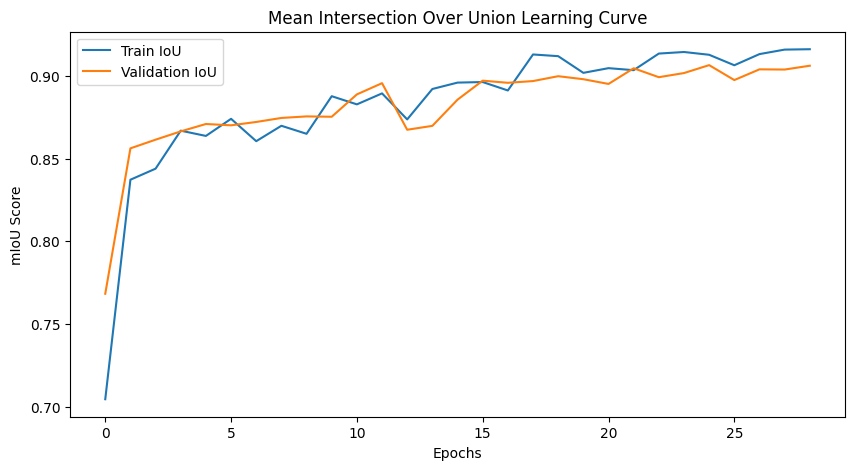

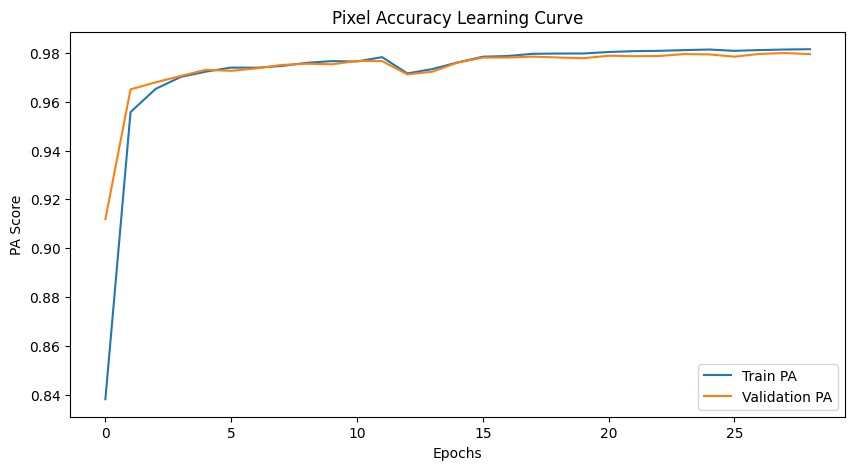

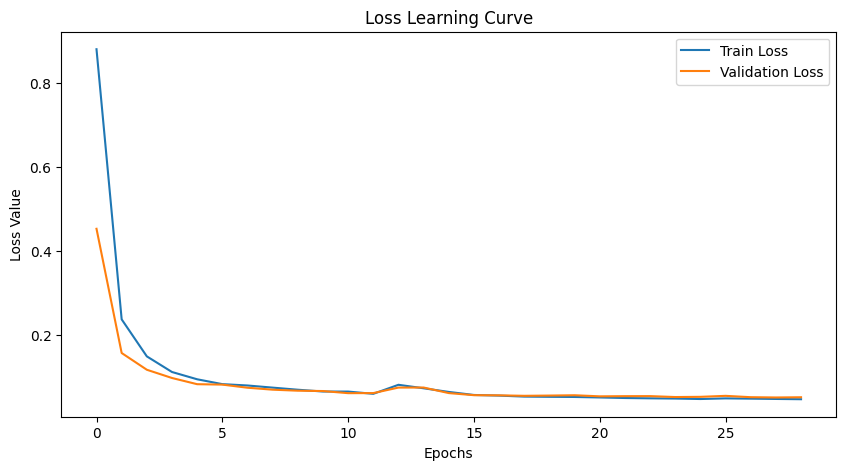

In [13]:
class Plot():
    
    def __init__(self, res):
        self.res = res

        self.visualize(metric1 = "tr_iou", metric2 = "val_iou", label1 = "Train IoU",
                  label2 = "Validation IoU", title = "Mean Intersection Over Union Learning Curve", ylabel = "mIoU Score")

        self.visualize(metric1 = "tr_pa", metric2 = "val_pa", label1 = "Train PA",
                  label2 = "Validation PA", title = "Pixel Accuracy Learning Curve", ylabel = "PA Score")

        self.visualize(metric1 = "tr_loss", metric2 = "val_loss", label1 = "Train Loss",
                  label2 = "Validation Loss", title = "Loss Learning Curve", ylabel = "Loss Value")

    def plot(self, metric, label): 
        plt.plot(self.res[metric], label = label)

    def decorate(self, ylabel, title): 
        plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()

    def visualize(self, metric1, metric2, label1, label2, title, ylabel):
        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1); self.plot(metric2, label2)
        self.decorate(ylabel, title)

Plot(history)

# Build the testing loop

In [15]:
class Test():
    def __init__(self, model, test_dl, loss_fn, device):
        self.model = model
        self.test_dl = test_dl
        self.loss_fn = loss_fn
        self.device = device
    
    def run(self):
        self.model.eval()  # Set model to evaluation mode
        test_loss = 0
        test_iou = 0
        test_pa = 0
        test_len = len(self.test_dl)

        ims = []
        gts = []
        preds = []

        with torch.no_grad():
            for batch in tqdm(self.test_dl):
                ims_batch, gts_batch = batch
                ims_batch, gts_batch = ims_batch.to(self.device), gts_batch.to(self.device)

                # Forward pass
                preds_batch = self.model(ims_batch)
                
                # Calculate metrics
                met = Metrics(preds_batch, gts_batch, self.loss_fn)
                test_loss += met.loss().item()
                test_iou += met.mIoU()
                test_pa += met.PA()

                # Collect data for visualization
                preds_batch = torch.argmax(preds_batch, dim=1)
                ims.extend(ims_batch.cpu())
                gts.extend(gts_batch.cpu())
                preds.extend(preds_batch.cpu())

        # Calculate average metrics
        test_loss /= test_len
        test_iou /= test_len
        test_pa /= test_len

        return ims, gts, preds, test_loss, test_iou, test_pa

In [16]:
test = Test(model, test_dl, loss_fn, device)
ims, gts, preds, test_loss, test_iou, test_pa = test.run()

print(f"Test Loss: {test_loss:.4f}")
print(f"Test mIoU: {test_iou:.4f}")
print(f"Test PA: {test_pa:.4f}")

100%|█████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 46.79it/s]

Test Loss: 0.0612
Test mIoU: 0.9136
Test PA: 0.9757


# Visualize testing results

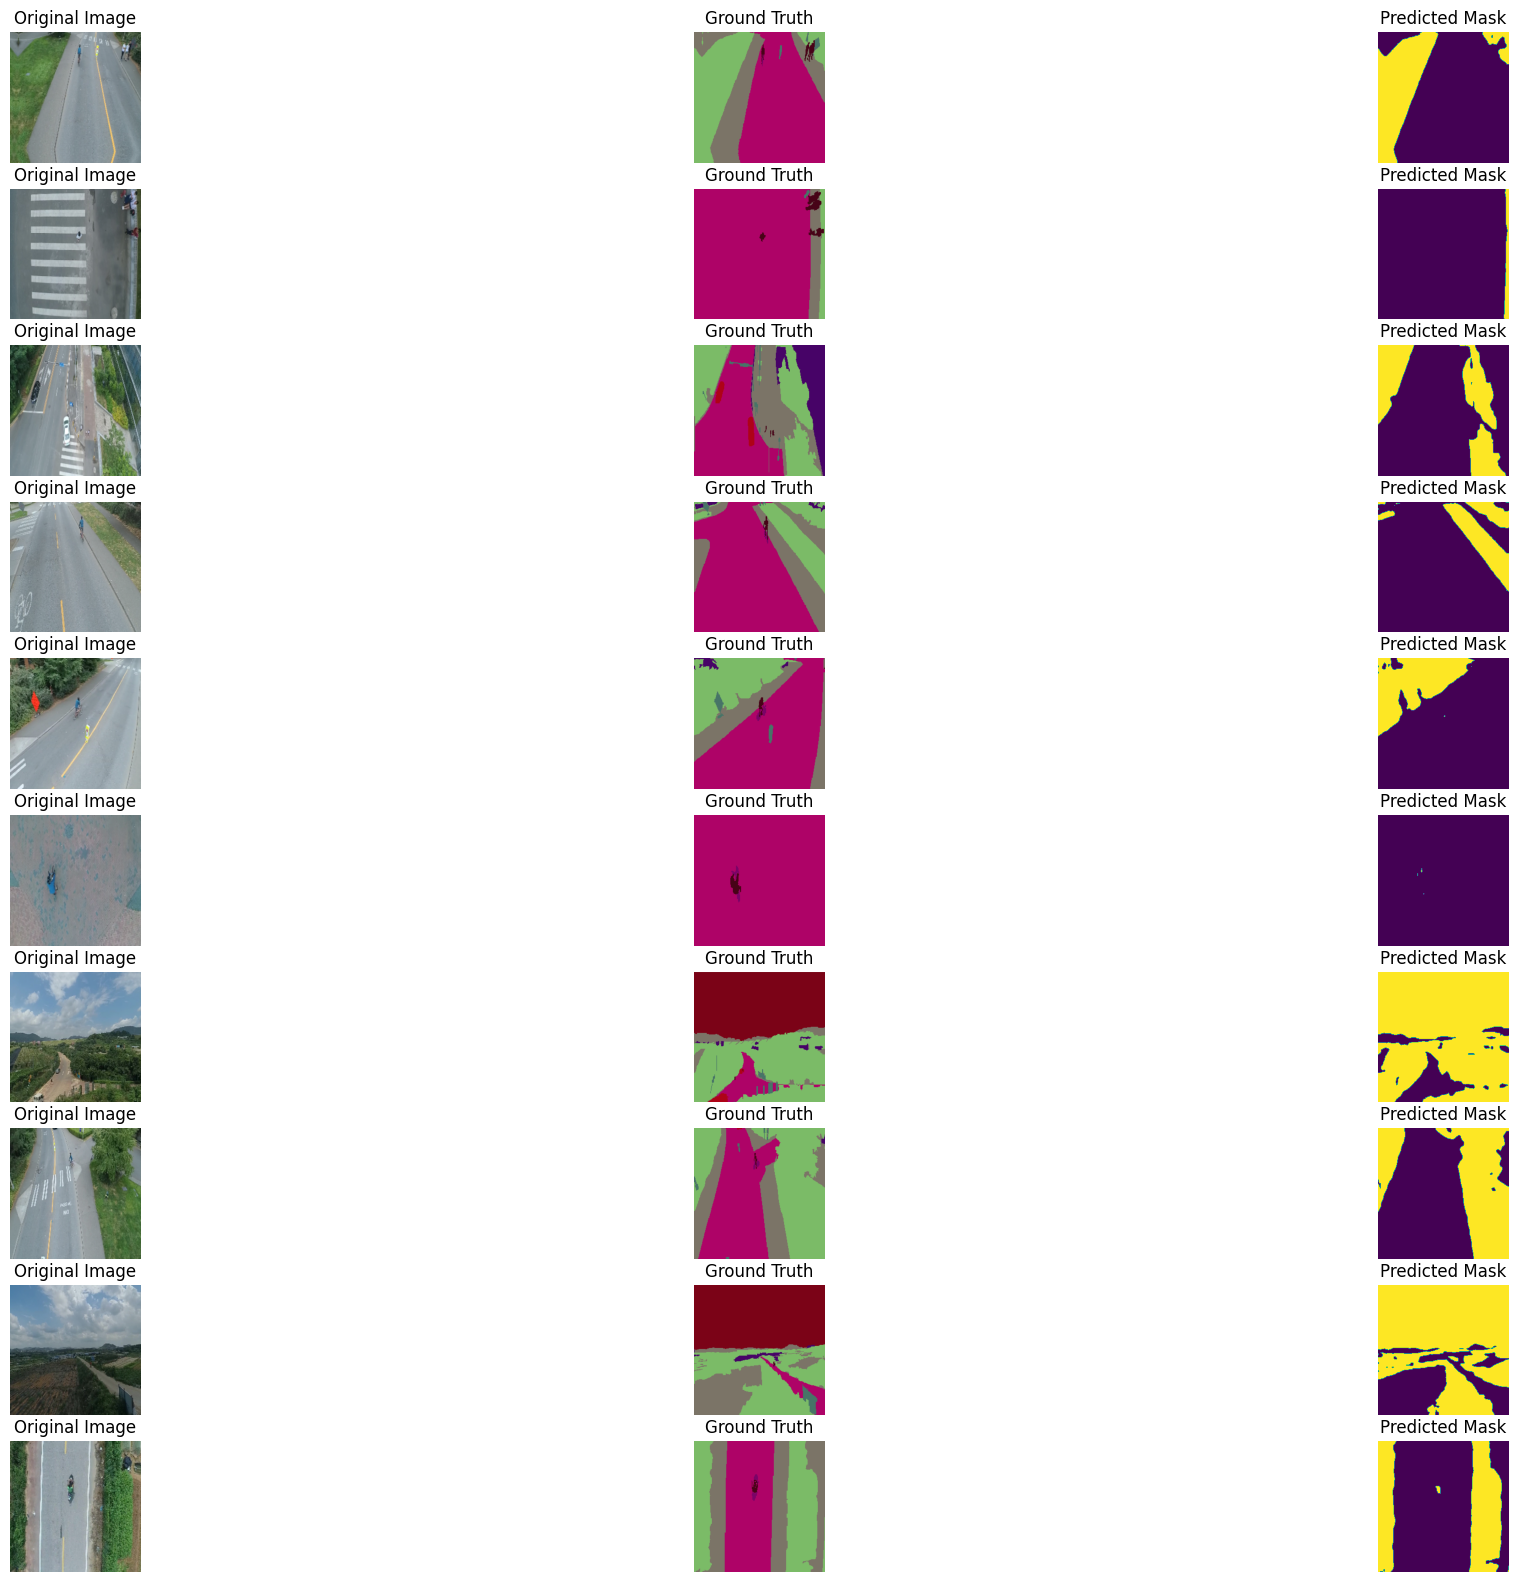

In [24]:
def inference(dl, model, device, n_ims = 30):

    cols = n_ims // 3
    rows = n_ims // cols

    count = 1
    ims = []
    gts = []
    preds = []
    indices = [random.randint(0, len(dl.dataset) - 1) for _ in range(n_ims)]

    for idx, data in enumerate(dl):

        if idx not in indices: 
            continue
        else:
            im, gt = data
            
            # Get predicted mask
            with torch.no_grad(): 
                pred = torch.argmax(model(im.to(device)), dim = 1)
            
            ims.append(im)
            gts.append(gt)
            preds.append(pred)

    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: 
            break

        # First plot
        count = plot(cols, rows, count, im)

        # Second plot
        count = plot(cols, rows, count, im = gt, gt = True, title = "Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")

model = torch.load("saved_models/aerospaces_best_model.pt")

inference(dl = test_dl, model = model, device = device)